# ETHZ: 227-0966-00L
# Quantitative Big Imaging
# March 26, 2019

## Shape Analysis

### Anders Kaestner

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})

# Literature / Useful References

- Jean Claude, Morphometry with R
    - [Online](http://link.springer.com/book/10.1007%2F978-0-387-77789-4) through ETHZ
    - [Buy it](http://www.amazon.com/Morphometrics-R-Use-Julien-Claude/dp/038777789X)
- John C. Russ, “The Image Processing Handbook”,(Boca Raton, CRC Press)
    - Available [online](http://dx.doi.org/10.1201/9780203881095) within domain ethz.ch (or proxy.ethz.ch / public VPN) 
- Principal Component Analysis
    - Venables, W. N. and B. D. Ripley (2002). Modern Applied Statistics with S, Springer-Verlag
- Shape Tensors
    - http://www.cs.utah.edu/~gk/papers/vissym04/
    - Doube, M.,et al. (2010). BoneJ: Free and extensible bone image analysis in ImageJ. Bone, 47, 1076–9. doi:10.1016/j.bone.2010.08.023
    - Mader, K. , et al. (2013). A quantitative framework for the 3D characterization of the osteocyte lacunar system. Bone, 57(1), 142–154. doi:10.1016/j.bone.2013.06.026
 
    - Wilhelm Burger, Mark Burge. Principles of Digital Image Processing: Core Algorithms. Springer-Verlag, London, 2009.
    -  B. Jähne. Digital Image Processing. Springer-Verlag,
           Berlin-Heidelberg, 6. edition, 2005.
    -  T. H. Reiss. Recognizing Planar Objects Using Invariant Image
           Features, from Lecture notes in computer science, p. 676. Springer,
           Berlin, 1993.
    - http://en.wikipedia.org/wiki/Image_moment
    
 

# Previously on QBI ...

<table>
    <tr><th>Image Enhancment</th><th>Segmentation</th><th>Automatic Methods</th></tr>
    <tr>
    <td>
        
- Highlighting the contrast of interest
- Minimizing Noise

    </td>
    <td>
    
- Understanding value histograms
- Dealing with multi-valued data
    
    </td>
    <td>
    
- Hysteresis Method
- K-Means Analysis

    </td>    
    </tr>
    <tr><th>Regions of Interest</th><th>Machine Learning</th><th></th></tr>
    <tr><td>
    
- Contouring

    </td><td></td></tr>
    </table>


# Learning Objectives

## Motivation (Why and How?)
- How do we quantify where and __how big__ our objects are?
- How can we say something about the __shape__?
- How can we compare objects of __different sizes__?
- How can we __compare two images__ on the basis of the shape as calculated from the images?
- How can we put objects into an 
    - finite element simulation? 
    - or make pretty renderings?

# Outline

- Motivation (Why and How?)
- Object Characterization
- Volume
- Center and Extents
- Anisotropy

## Metrics

- Shape Tensor
- Principal Component Analysis
- Ellipsoid Representation
- Scale-free metrics
- Anisotropy, Oblateness
- Meshing
 - Marching Cubes
 - Isosurfaces
- Surface Area

# Motivation


We have dramatically simplified our data, but there is still too much.

- We perform an experiment bone to see how big the cells are inside the tissue
$$\downarrow$$ ![Bone Measurement](ext-figures/tomoimage.png) 

### 2560 x 2560 x 2160 x 32 bit
_56GB / sample_
- Filtering and Enhancement!  
$$\downarrow$$
- 56GB of less noisy data

***

- __Segmentation__

$$\downarrow$$

### 2560 x 2560 x 2160 x 1 bit
(1.75GB / sample)

- Still an aweful lot of data

# What did we want in the first place?

### _Single number_ :
* volume fraction,
* cell count,
* average cell stretch,
* cell volume variability

# Component labelling

### Segmentation
- Segmentation identified pixels belonging to some class
    - a single set containing all pixels!
    
### To measure objects in an image, they need to be uniquely identified.
- Basic component labelling
    - give the same label to all pixels touching each other.
    - has its drawbacks... touching item are treated as one

# Component Labeling

Once we have a clearly segmented image, it is often helpful to identify the sub-components of this image. The easist method for identifying these subcomponents is called component labeling which again uses the neighborhood $\mathcal{N}$ as a criterion for connectivity, resulting in pixels which are touching being part of the same object.


In general, the approach works well since usually when different regions are touching, they are related. It runs into issues when you have multiple regions which agglomerate together, for example a continuous pore network (1 object) or a cluster of touching cells.

Here we show some examples from Cityscape Data taken in Aachen (https://www.cityscapes-dataset.com/)

image dimensions (256, 512, 4) (256, 512)


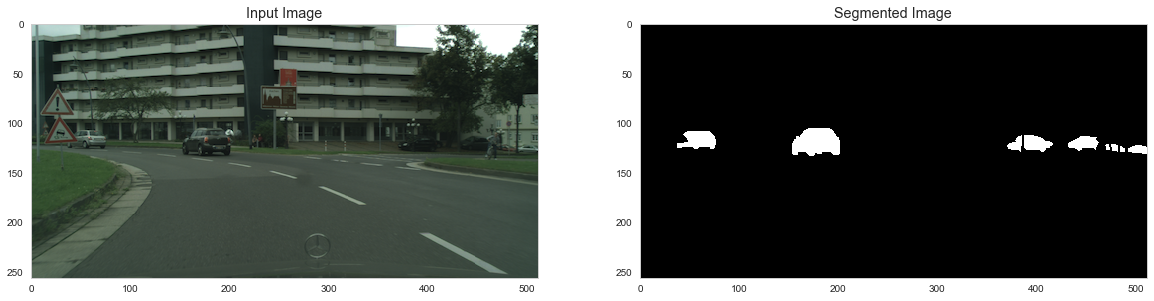

In [2]:
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

car_img = imread('ext-figures/aachen_img.png')
seg_img = imread('ext-figures/aachen_label.png')[::4, ::4] == 26
print('image dimensions', car_img.shape, seg_img.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.imshow(car_img)
ax1.set_title('Input Image')

ax2.imshow(seg_img, cmap='bone')
ax2.set_title('Segmented Image');

The more general formulation of the problem is for networks (roads, computers, social). Are the points start and finish connected?

In [3]:
from skimage.morphology import label
help(label)

Help on function label in module skimage.measure._label:

label(input, neighbors=None, background=None, return_num=False, connectivity=None)
    Label connected regions of an integer array.
    
    Two pixels are connected when they are neighbors and have the same value.
    In 2D, they can be neighbors either in a 1- or 2-connected sense.
    The value refers to the maximum number of orthogonal hops to consider a
    pixel/voxel a neighbor::
    
      1-connectivity     2-connectivity     diagonal connection close-up
    
           [ ]           [ ]  [ ]  [ ]             [ ]
            |               \  |  /                 |  <- hop 2
      [ ]--[x]--[ ]      [ ]--[x]--[ ]        [x]--[ ]
            |               /  |  \             hop 1
           [ ]           [ ]  [ ]  [ ]
    
    Parameters
    ----------
    input : ndarray of dtype int
        Image to label.
    neighbors : {4, 8}, int, optional
        Whether to use 4- or 8-"connectivity".
        In 3D, 4-"connect

Text(0.5, 1.0, 'Labeled Image')

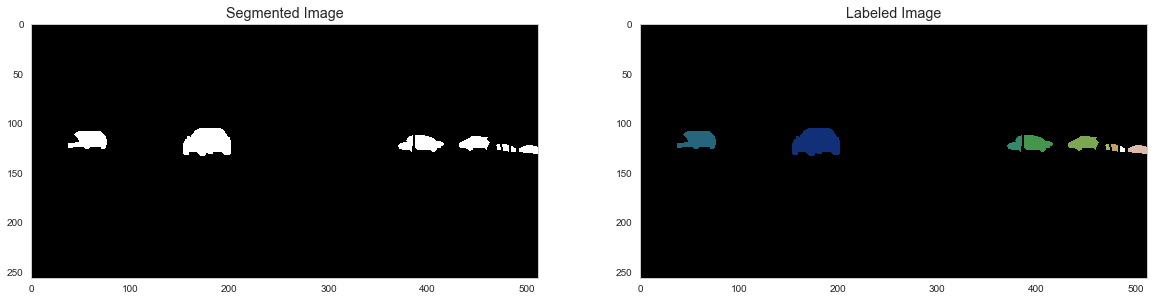

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.imshow(seg_img, cmap='bone')
ax1.set_title('Segmented Image')
lab_img = label(seg_img)
ax2.imshow(lab_img, cmap=plt.cm.gist_earth)
ax2.set_title('Labeled Image')

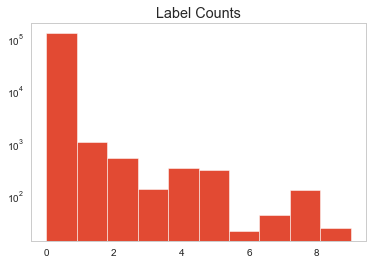

In [5]:
fig, (ax3) = plt.subplots(1, 1)
ax3.hist(lab_img.ravel())
ax3.set_title('Label Counts')
ax3.set_yscale('log')

# Component Labeling: Algorithm

We start off with all of the pixels in either foreground (1) or background (0)

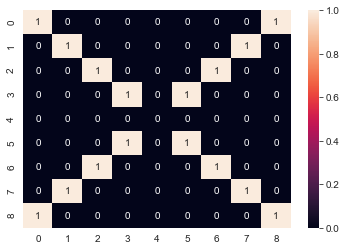

In [6]:
from skimage.morphology import label
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
seg_img = np.eye(9, dtype=int)
seg_img[4, 4] = 0
seg_img += seg_img[::-1]
sns.heatmap(seg_img, annot=True, fmt="d")

Give each point in the image a unique label
- For each point $(x,y)\in\text{Foreground}$
 - Set value to $I_{x,y} = x+y*width+1$

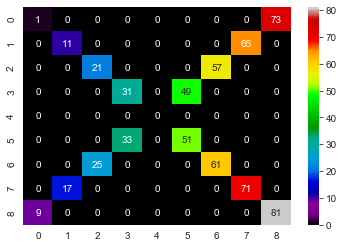

In [7]:
idx_img = np.zeros_like(seg_img)
for x in range(seg_img.shape[0]):
    for y in range(seg_img.shape[1]):
        if seg_img[x, y] > 0:
            idx_img[x, y] = x+y*seg_img.shape[0]+1
sns.heatmap(idx_img, annot=True,
            fmt="d", cmap='nipy_spectral')

In a [brushfire](http://www.sciencedirect.com/science/article/pii/S0921889007000966)-style algorithm
- For each point $(x,y)\in\text{Foreground}$
    - For each point $(x^{\prime},y^{\prime})\in\mathcal{N}(x,y)$
    - if $(x^{\prime},y^{\prime})\in\text{Foreground}$
        - Set the label to $\min(I_{x,y}, I_{x^{\prime},y^{\prime}})$
- Repeat until no more labels have been changed

(0, 8) 73 vs (1, 7) 65 -> 65
(1, 1) 11 vs (0, 0) 1 -> 1
(1, 7) 65 vs (2, 6) 57 -> 57
(2, 2) 21 vs (1, 1) 11 -> 11
(2, 6) 57 vs (3, 5) 49 -> 49
(3, 3) 31 vs (2, 2) 21 -> 21
(5, 3) 33 vs (6, 2) 25 -> 25
(6, 2) 25 vs (7, 1) 17 -> 17
(6, 6) 61 vs (5, 5) 51 -> 51
(7, 1) 17 vs (8, 0) 9 -> 9
(7, 7) 71 vs (6, 6) 61 -> 61
(8, 8) 81 vs (7, 7) 71 -> 71
Iteration 1 Groups 12 Changes 12
(0, 8) 65 vs (1, 7) 57 -> 57
(1, 7) 57 vs (2, 6) 49 -> 49
(2, 2) 11 vs (1, 1) 1 -> 1
(3, 3) 21 vs (2, 2) 11 -> 11
(5, 3) 25 vs (6, 2) 17 -> 17
(6, 2) 17 vs (7, 1) 9 -> 9
(7, 7) 61 vs (6, 6) 51 -> 51
(8, 8) 71 vs (7, 7) 61 -> 61
Iteration 2 Groups 8 Changes 8
(0, 8) 57 vs (1, 7) 49 -> 49
(3, 3) 11 vs (2, 2) 1 -> 1
(5, 3) 17 vs (6, 2) 9 -> 9
(8, 8) 61 vs (7, 7) 51 -> 51
Iteration 3 Groups 4 Changes 4
Done


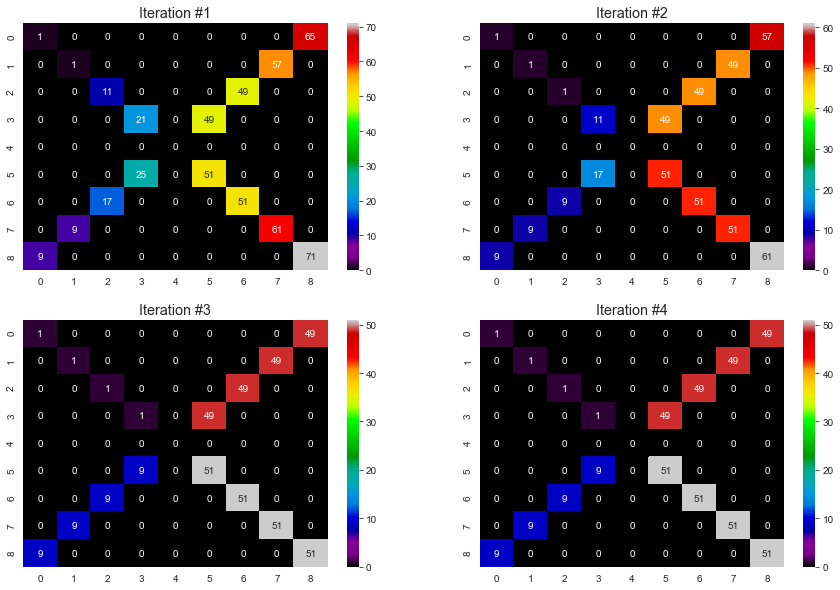

In [8]:
fig, m_axs = plt.subplots(2, 2, figsize=(15, 10))
last_img = idx_img.copy()
img_list = [last_img]
for iteration, c_ax in enumerate(m_axs.flatten(), 1):
    cur_img = last_img.copy()

    for x in range(last_img.shape[0]):
        for y in range(last_img.shape[1]):
            if last_img[x, y] > 0:
                i_xy = last_img[x, y]
                for xp in [-1, 0, 1]:
                    if (x+xp < last_img.shape[0]) and (x+xp >= 0):
                        for yp in [-1, 0, 1]:
                            if (y+yp < last_img.shape[1]) and (y+yp >= 0):
                                i_xpyp = last_img[x+xp, y+yp]
                                if i_xpyp > 0:

                                    new_val = min(i_xy, i_xpyp, cur_img[x, y])
                                    if cur_img[x, y] != new_val:
                                        print((x, y), i_xy, 'vs', (x+xp,
                                                                   y+yp), i_xpyp, '->', new_val)
                                        cur_img[x, y] = new_val

    img_list += [cur_img]
    sns.heatmap(cur_img,
                annot=True,
                fmt="d",
                cmap='nipy_spectral',
                ax=c_ax)
    c_ax.set_title('Iteration #{}'.format(iteration))
    if (cur_img == last_img).all():
        print('Done')
        break
    else:
        print('Iteration', iteration,
              'Groups', len(np.unique(cur_img[cur_img > 0].ravel())),
              'Changes', np.sum(cur_img != last_img))
        last_img = cur_img

- The image very quickly converges and after 4 iterations the task is complete. 

- For larger more complicated images with thousands of components this task can take longer, 
- There exist much more efficient [algorithms](https://www.cs.princeton.edu/~rs/AlgsDS07/01UnionFind.pdf) for labeling components which alleviate this issue.

### Let's animate the iterations

In [9]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
fig, c_ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)


def update_frame(i):
    plt.cla()
    sns.heatmap(img_list[i],
                annot=True,
                fmt="d",
                cmap='nipy_spectral',
                ax=c_ax,
                cbar=False,
                vmin=img_list[0].min(),
                vmax=img_list[0].max())
    c_ax.set_title('Iteration #{}, Groups {}'.format(i+1,
                                                     len(np.unique(img_list[i][img_list[i] > 0].ravel()))))
# write animation frames
anim_code = FuncAnimation(fig, update_frame, frames=len(img_list)-1,
                          interval=1000, repeat_delay=2000).to_html5_video()
plt.close('all')
HTML(anim_code)

# Bigger Images
How does the same algorithm apply to bigger images

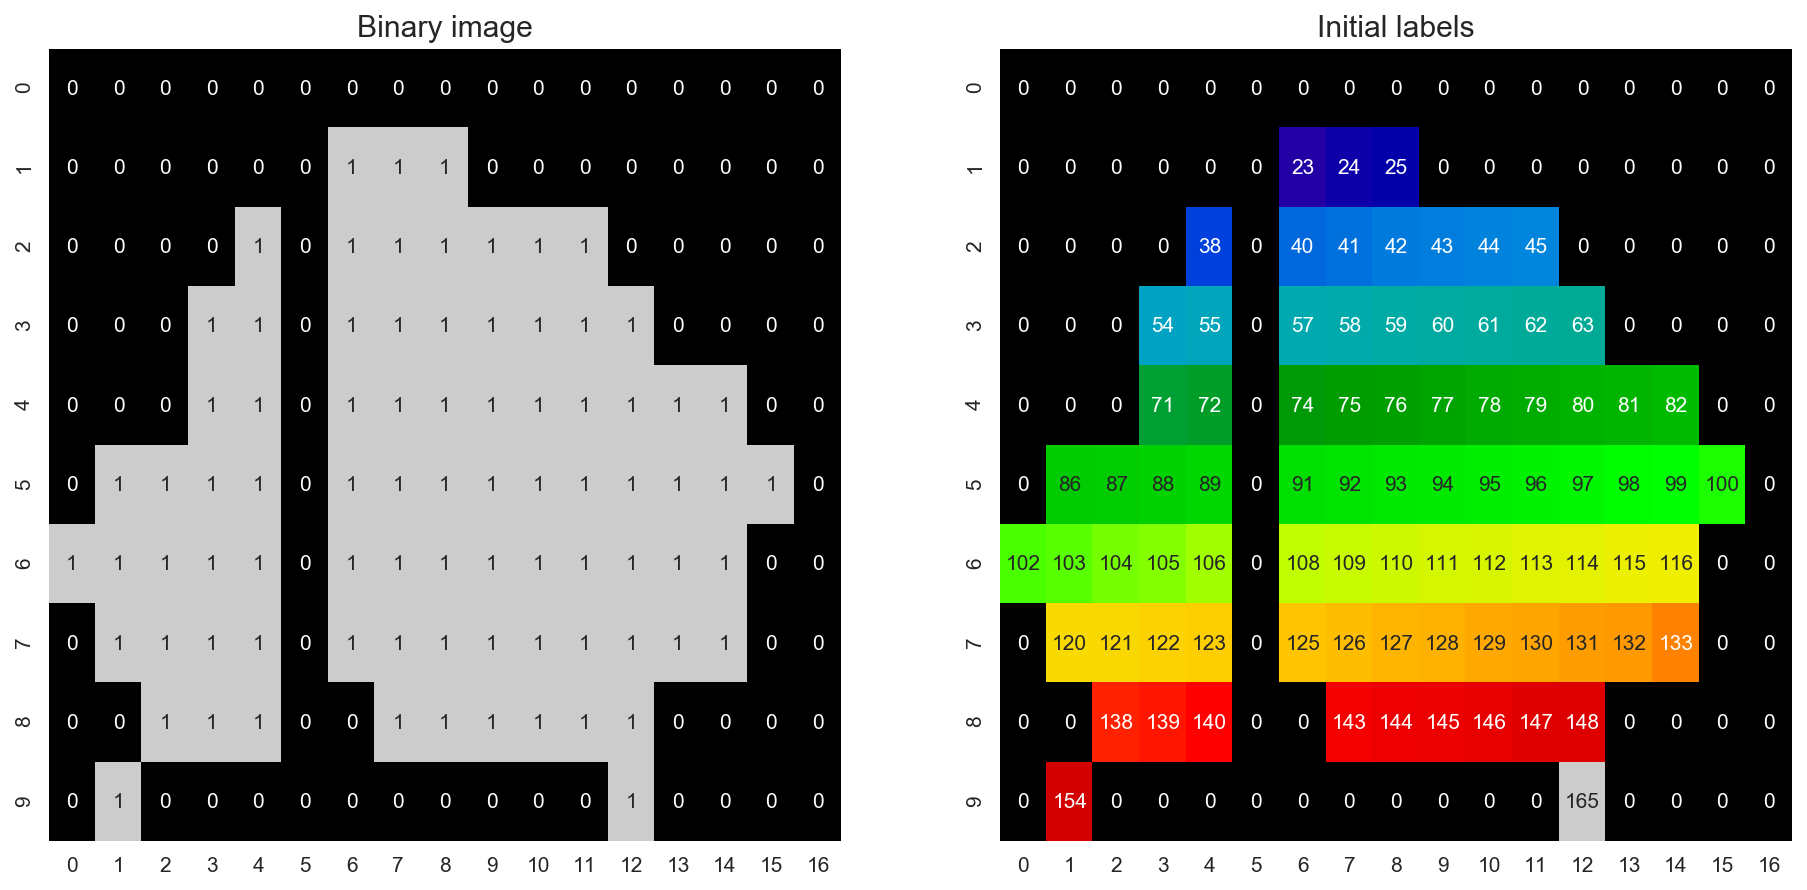

In [10]:
from skimage.io import imread
from skimage.morphology import label
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
seg_img = (imread('ext-figures/aachen_label.png')[::4, ::4] == 26)[110:130:2, 370:420:3]
seg_img[9, 1] = 1
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), dpi=150)
sns.heatmap(seg_img, annot=True, fmt="d", ax=ax1,
            cmap='nipy_spectral', cbar=False)
ax1.set_title('Binary image')

idx_img = seg_img * np.arange(len(seg_img.ravel())).reshape(seg_img.shape)
sns.heatmap(idx_img, annot=True, fmt="d", ax=ax2,
            cmap='nipy_spectral', cbar=False)
ax2.set_title('Initial labels');

# Run the labelling on the car image

In [11]:
last_img = idx_img.copy()
img_list = [last_img]
for iteration in range(99):
    cur_img = last_img.copy()
    for x in range(last_img.shape[0]):
        for y in range(last_img.shape[1]):
            if last_img[x, y] > 0:
                i_xy = last_img[x, y]
                for xp in [-1, 0, 1]:
                    if (x+xp < last_img.shape[0]) and (x+xp >= 0):
                        for yp in [-1, 0, 1]:
                            if (y+yp < last_img.shape[1]) and (y+yp >= 0):
                                i_xpyp = last_img[x+xp, y+yp]
                                if i_xpyp > 0:
                                    new_val = min(i_xy, i_xpyp, cur_img[x, y])
                                    if cur_img[x, y] != new_val:
                                        cur_img[x, y] = new_val

    img_list += [cur_img] # stores the current image in the iteration list
    if (cur_img == last_img).all():
        print('Done')
        break
    else:
        print('Iteration', iteration,
              'Groups', len(np.unique(cur_img[cur_img > 0].ravel())),
              'Changes', np.sum(cur_img != last_img))
        last_img = cur_img

Iteration 0 Groups 62 Changes 79
Iteration 1 Groups 46 Changes 74
Iteration 2 Groups 32 Changes 68
Iteration 3 Groups 22 Changes 59
Iteration 4 Groups 14 Changes 46
Iteration 5 Groups 8 Changes 31
Iteration 6 Groups 5 Changes 17
Iteration 7 Groups 3 Changes 6
Iteration 8 Groups 2 Changes 1
Done


In [12]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
fig, c_ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)

def update_frame(i):
    plt.cla()
    sns.heatmap(img_list[i],
                annot=True,
                fmt="d",
                cmap='nipy_spectral',
                ax=c_ax,
                cbar=False,
                vmin=img_list[0].min(),
                vmax=img_list[0].max())
    c_ax.set_title('Iteration #{}, Groups {}'.format(i+1,
                                                     len(np.unique(img_list[i][img_list[i] > 0].ravel()))))


# write animation frames
anim_code = FuncAnimation(fig,
                          update_frame,
                          frames=len(img_list)-1,
                          interval=500,
                          repeat_delay=1000).to_html5_video()
plt.close('all')
HTML(anim_code)

# Different Neighborhoods
We can expand beyond the 3x3 neighborhood to a 5x5 for example

In [13]:
last_img = idx_img.copy()
img_list = [last_img]
for iteration in range(99):
    cur_img = last_img.copy()
    for x in range(last_img.shape[0]):
        for y in range(last_img.shape[1]):
            if last_img[x, y] > 0:
                i_xy = last_img[x, y]
                for xp in [-2, -1, 0, 1, 2]:
                    if (x+xp < last_img.shape[0]) and (x+xp >= 0):
                        for yp in [-2, -1, 0, 1, 2]:
                            if (y+yp < last_img.shape[1]) and (y+yp >= 0):
                                i_xpyp = last_img[x+xp, y+yp]
                                if i_xpyp > 0:
                                    new_val = min(i_xy, i_xpyp, cur_img[x, y])
                                    if cur_img[x, y] != new_val:
                                        cur_img[x, y] = new_val

    img_list += [cur_img]
    if (cur_img == last_img).all():
        print('Done')
        break
    else:
        print('Iteration', iteration,
              'Groups', len(np.unique(cur_img[cur_img > 0].ravel())),
              'Changes', np.sum(cur_img != last_img))
        last_img = cur_img

fig, c_ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)


def update_frame(i):
    plt.cla()
    sns.heatmap(img_list[i],
                annot=True,
                fmt="d",
                cmap='nipy_spectral',
                ax=c_ax,
                cbar=False,
                vmin=img_list[0].min(),
                vmax=img_list[0].max())
    c_ax.set_title('Iteration #{}, Groups {}'.format(i+1,
                                                     len(np.unique(img_list[i][img_list[i] > 0].ravel()))))


# write animation frames
anim_code = FuncAnimation(fig,
                          update_frame,
                          frames=len(img_list)-1,
                          interval=500,
                          repeat_delay=1000).to_html5_video()
plt.close('all')
HTML(anim_code)

Iteration 0 Groups 49 Changes 81
Iteration 1 Groups 24 Changes 71
Iteration 2 Groups 8 Changes 51
Iteration 3 Groups 2 Changes 20
Iteration 4 Groups 1 Changes 1
Done


# Or a smaller kernel
By using a smaller kernel (in this case where $\sqrt{x^2+y^2}<=1$, we cause the number of iterations to fill to increase and prevent the last pixel from being grouped since it is only connected diagonally

|   |   |   |
|--:|--:|--:|
|  0|  1|  0|
|  1|  1|  1|
|  0|  1|  0|


In [14]:
last_img = idx_img.copy()
img_list = [last_img]
for iteration in range(99):
    cur_img = last_img.copy()
    for x in range(last_img.shape[0]):
        for y in range(last_img.shape[1]):
            if last_img[x, y] > 0:
                i_xy = last_img[x, y]
                for xp in [-1, 0, 1]:
                    if (x+xp < last_img.shape[0]) and (x+xp >= 0):
                        for yp in [-1, 0, 1]:
                            if np.abs(xp)+np.abs(yp) <= 1:
                                if (y+yp < last_img.shape[1]) and (y+yp >= 0):
                                    i_xpyp = last_img[x+xp, y+yp]
                                    if i_xpyp > 0:
                                        new_val = min(
                                            i_xy, i_xpyp, cur_img[x, y])
                                        if cur_img[x, y] != new_val:
                                            cur_img[x, y] = new_val

    img_list += [cur_img]
    if (cur_img == last_img).all():
        print('Done')
        break
    else:
        print('Iteration', iteration,
              'Groups', len(np.unique(cur_img[cur_img > 0].ravel())),
              'Changes', np.sum(cur_img != last_img))
        last_img = cur_img

fig, c_ax = plt.subplots(1, 1, figsize=(6, 6), dpi=100)


def update_frame(i):
    plt.cla()
    sns.heatmap(img_list[i],
                annot=True,
                fmt="d",
                cmap='nipy_spectral',
                ax=c_ax,
                cbar=False,
                vmin=img_list[0].min(),
                vmax=img_list[0].max())
    c_ax.set_title('Iteration #{}, Groups {}'.format(i+1,
                                                     len(np.unique(img_list[i][img_list[i] > 0].ravel()))))


# write animation frames
anim_code = FuncAnimation(fig,
                          update_frame,
                          frames=len(img_list)-1,
                          interval=500,
                          repeat_delay=1000).to_html5_video()
plt.close('all')
HTML(anim_code)

Iteration 0 Groups 68 Changes 76
Iteration 1 Groups 54 Changes 73
Iteration 2 Groups 42 Changes 67
Iteration 3 Groups 31 Changes 62
Iteration 4 Groups 21 Changes 57
Iteration 5 Groups 13 Changes 49
Iteration 6 Groups 11 Changes 39
Iteration 7 Groups 9 Changes 34
Iteration 8 Groups 8 Changes 25
Iteration 9 Groups 7 Changes 20
Iteration 10 Groups 6 Changes 15
Iteration 11 Groups 5 Changes 10
Iteration 12 Groups 4 Changes 6
Iteration 13 Groups 3 Changes 2
Done


# Comparing different neighborhoods

|Neighborhood size|Iterations| Segments |
|----------------:|---------:|---------:|
|      3x3        |    9     |    2     |
|      5x5        |    5     |    1     |
|      cross      |    14    |    3     |     


# Component Labeling: Beyond


Now all the voxels which are connected have the same label. We can then perform simple metrics like

- counting the number of voxels in each label to estimate volume.
- looking at the change in volume during erosion or dilation to estimate surface area

### What we would like to to do

- Count the cells
- Say something about the cells
- Compare the cells in this image to another image


... But where do we start?

# Object position - Center of Volume (COV): With a single object

$$ I_{id}(x,y) = 
\begin{cases}
1, & L(x,y) = id \\
0, & \text{otherwise}
\end{cases}$$



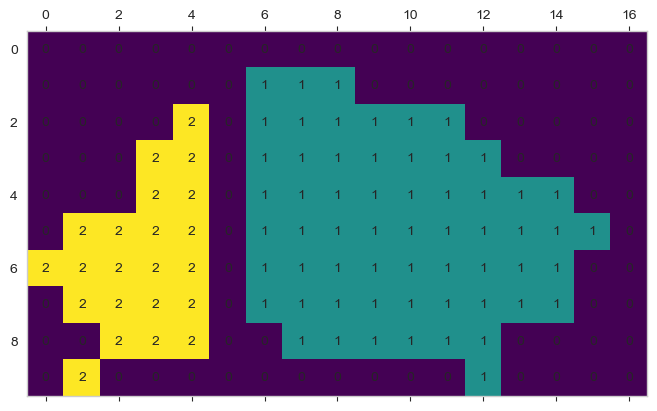

In [16]:
from IPython.display import Markdown
from skimage.io import imread
from skimage.morphology import label
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
seg_img = imread('ext-figures/aachen_label.png') == 26
seg_img = seg_img[::4, ::4]
seg_img = seg_img[110:130:2, 370:420:3]
seg_img[9, 1] = 1
lab_img = label(seg_img)
fig, ax = plt.subplots(figsize=[8,6],dpi=100)
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow(lab_img,cmap='viridis')

for (i, j), z in np.ndenumerate(lab_img):
    ax.text(j, i, '{}'.format(z), ha='center', va='center')

### Define a center
$$ \bar{x} = \frac{1}{N} \sum_{\vec{v}\in I_{id}} \vec{v}\cdot\vec{i} $$
$$ \bar{y} = \frac{1}{N} \sum_{\vec{v}\in I_{id}} \vec{v}\cdot\vec{j} $$
$$ \bar{z} = \frac{1}{N} \sum_{\vec{v}\in I_{id}} \vec{v}\cdot\vec{k} $$

i.e. the average position of all pixels in each direction.

x,y coordinates [(2, 4), (3, 3), (3, 4), (4, 3), (4, 4), (5, 1), (5, 2), (5, 3), (5, 4), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (7, 1), (7, 2), (7, 3), (7, 4), (8, 2), (8, 3), (8, 4), (9, 1)]


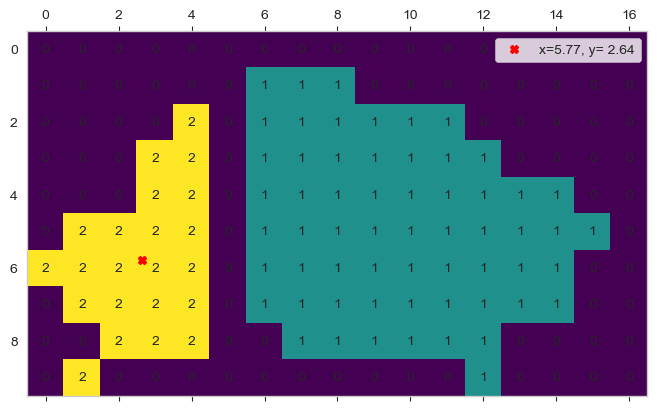

In [19]:
x_coord, y_coord = [], []
for x in range(lab_img.shape[0]):
    for y in range(lab_img.shape[1]):
        if lab_img[x, y] == 2:
            x_coord += [x]
            y_coord += [y]
print('x,y coordinates', list(zip(x_coord, y_coord)))

fig, ax = plt.subplots(figsize=[8,6],dpi=100)
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow(lab_img,cmap='viridis')
ax.plot(np.mean(y_coord),np.mean(x_coord),'rX',
        label="x={0:0.2f}, y= {1:0.2f}".format(np.mean(x_coord), np.mean(y_coord)))
ax.legend()
for (i, j), z in np.ndenumerate(lab_img):
    ax.text(j, i, '{}'.format(z), ha='center', va='center')

# Center of Mass (COM): With a single object

If the gray values are kept (or other meaningful ones are used), this can be seen as a weighted center of volume or center of mass (using $I_{gy}$ to distinguish it from the labels)

### Define a center
$$ \Sigma I_{gy} = \frac{1}{N} \sum_{\vec{v}\in I_{id}} I_{gy}(\vec{v}) $$
$$ \bar{x} = \frac{1}{\Sigma I_{gy}} \sum_{\vec{v}\in I_{id}} (\vec{v}\cdot\vec{i}) I_{gy}(\vec{v}) $$
$$ \bar{y} = \frac{1}{\Sigma I_{gy}} \sum_{\vec{v}\in I_{id}} (\vec{v}\cdot\vec{j}) I_{gy}(\vec{v}) $$
$$ \bar{z} = \frac{1}{\Sigma I_{gy}} \sum_{\vec{v}\in I_{id}} (\vec{v}\cdot\vec{k}) I_{gy}(\vec{v}) $$


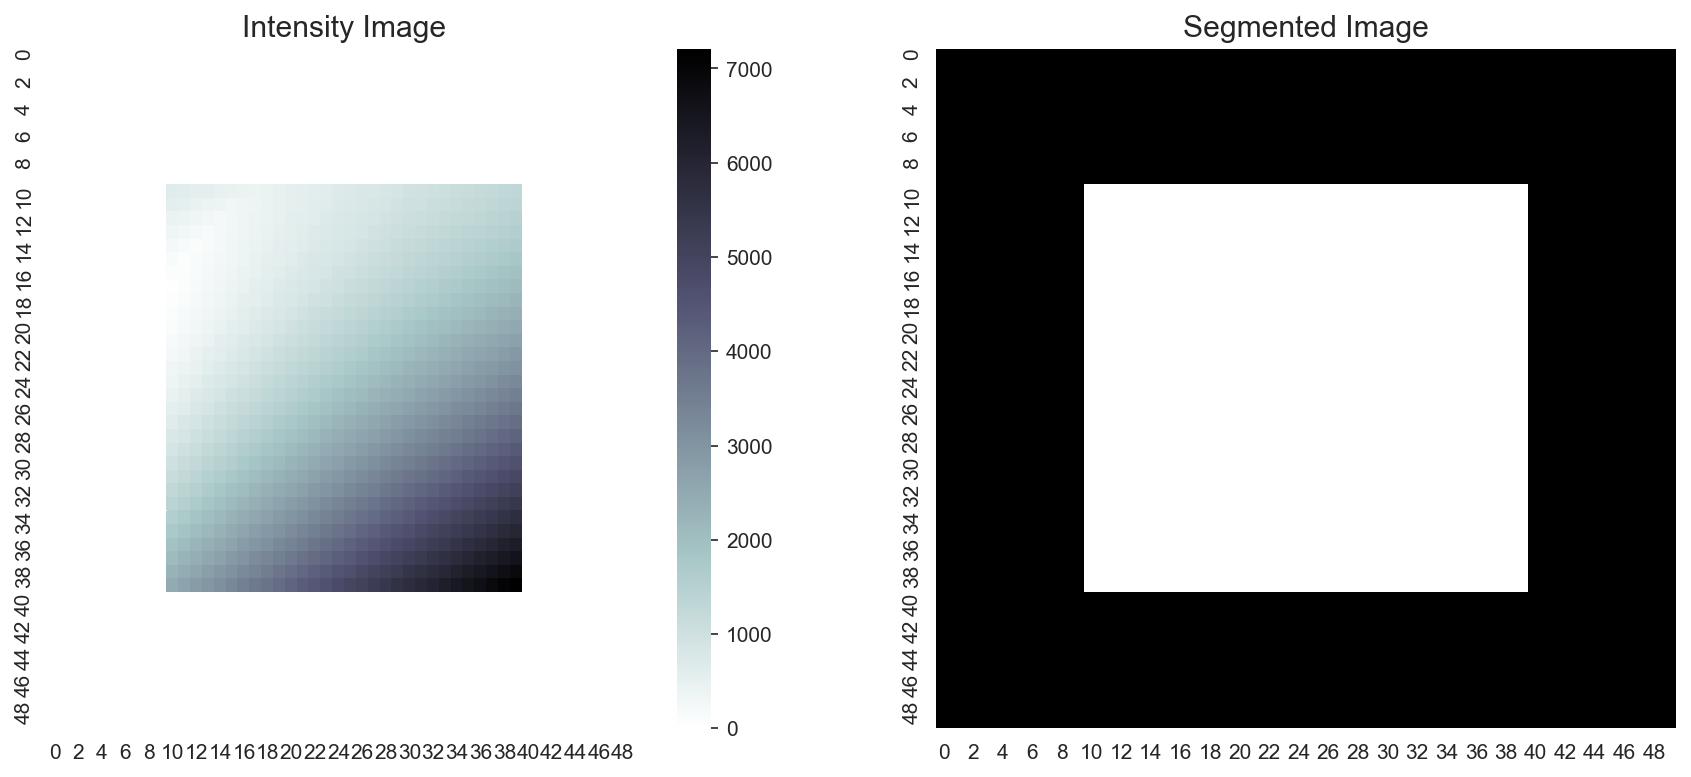

In [20]:
from IPython.display import Markdown, display
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


xx, yy = np.meshgrid(np.linspace(0, 10, 50),
                     np.linspace(0, 10, 50))
gray_img = 100*(np.abs(xx*yy-7) + np.square(yy-4))+0.25
gray_img *= np.abs(xx-5) < 3
gray_img *= np.abs(yy-5) < 3
gray_img[gray_img > 0] += 5
seg_img = (gray_img > 0).astype(int)
_, (ax1, ax2) = plt.subplots(1, 2,
                             figsize=(14, 6),
                             dpi=150)

sns.heatmap(gray_img,
            ax=ax1,
            cmap='bone_r',
            cbar=True)
ax1.set_title('Intensity Image')

sns.heatmap(seg_img,
            ax=ax2,
            cmap='bone',
            cbar=False)
ax2.set_title('Segmented Image');

## Center of Volume: 
- $\bar{x} = 24.50$
- $\bar{y} = 24.50 $

## Center of Mass: 
- $\bar{x}_m = 29.27$
- $\bar{y}_m = 27.90 $

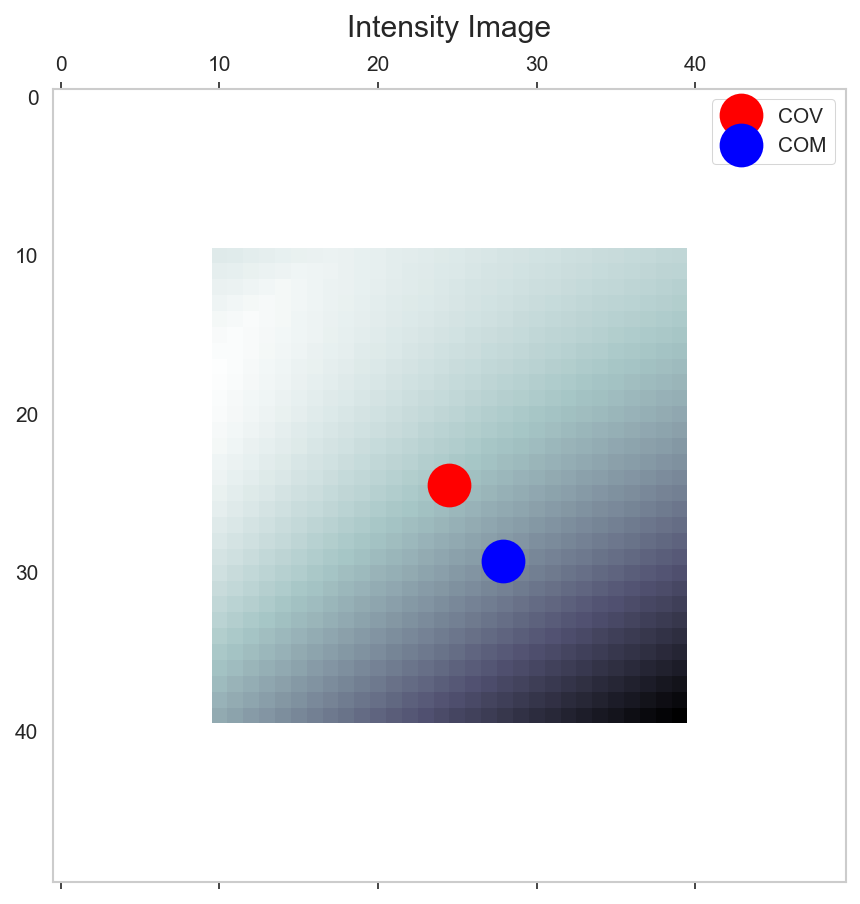

In [21]:
x_coord, y_coord, i_val = [], [], []
for x in range(seg_img.shape[0]):
    for y in range(seg_img.shape[1]):
        if seg_img[x, y] == 1:
            x_coord += [x]
            y_coord += [y]
            i_val += [gray_img[x, y]]

x_coord = np.array(x_coord)
y_coord = np.array(y_coord)
i_val = np.array(i_val)
cov_x = np.mean(x_coord)
cov_y = np.mean(y_coord)

display(Markdown("""## Center of Volume: 
- $\\bar{x} = %2.2f$
- $\\bar{y} = %2.2f $""" %
                 (cov_x, cov_y)));

com_x = np.sum(x_coord*i_val)/np.sum(i_val)
com_y = np.sum(y_coord*i_val)/np.sum(i_val)

display(Markdown("""## Center of Mass: 
- $\\bar{x}_m = %2.2f$
- $\\bar{y}_m = %2.2f $""" % (com_x, com_y)));

_, (ax1) = plt.subplots(1, 1,
                        figsize=(7, 7),
                        dpi=150)

ax1.matshow(gray_img,
            cmap='bone_r')
ax1.set_title('Intensity Image')
ax1.plot([cov_y], [cov_x], 'ro',
         label='COV', markersize=20)
ax1.plot([com_y], [com_x], 'bo',
         label='COM', markersize=20)
ax1.legend();

# Further object metrics

The center tells the position of an object. 

We want more! E.g. metrics like:
- Area
- Perimeter length
- Sphericity 
- Orientation

... and more

```regionprops``` gives us all this!


In [22]:
from skimage.measure import regionprops
help(regionprops)

Help on function regionprops in module skimage.measure._regionprops:

regionprops(label_image, intensity_image=None, cache=True, coordinates=None)
    Measure properties of labeled image regions.
    
    Parameters
    ----------
    label_image : (N, M) ndarray
        Labeled input image. Labels with value 0 are ignored.
    
        .. versionchanged:: 0.14.1
            Previously, ``label_image`` was processed by ``numpy.squeeze`` and
            so any number of singleton dimensions was allowed. This resulted in
            inconsistent handling of images with singleton dimensions. To
            recover the old behaviour, use
            ``regionprops(np.squeeze(label_image), ...)``.
    intensity_image : (N, M) ndarray, optional
        Intensity (i.e., input) image with same size as labeled image.
        Default is None.
    cache : bool, optional
        Determine whether to cache calculated properties. The computation is
        much faster for cached properties, whereas t

# Let's try regionprops on our image

In [23]:
from skimage.measure import regionprops
all_regs = regionprops(seg_img, intensity_image=gray_img)
for c_reg in all_regs:
    display(Markdown('# Region: {}'.format(c_reg.label)))
    for k in dir(c_reg):
        if not k.startswith('_') and ('image' not in k):
            display(Markdown('- {} {}'.format(k, getattr(c_reg, k))));

# Region: 1

- area 900

- bbox (10, 10, 40, 40)

- bbox_area 900

- centroid (24.5, 24.5)

- convex_area 900

- coords [[10 10]
 [10 11]
 [10 12]
 ...
 [39 37]
 [39 38]
 [39 39]]

- eccentricity 0.0

- equivalent_diameter 33.851375012865375

- euler_number 1

- extent 1.0

- filled_area 900

- inertia_tensor [[74.91666667 -0.        ]
 [-0.         74.91666667]]

- inertia_tensor_eigvals [74.91666666666667, 74.91666666666667]

- label 1

- local_centroid (14.5, 14.5)

- major_axis_length 34.62176579359676

- max_intensity 7207.624010828822

- mean_intensity 2223.9078740339673

- min_intensity 41.443252811328634

- minor_axis_length 34.62176579359676

- moments [[9.00000000e+02 1.30500000e+04 2.56650000e+05 5.67675000e+06]
 [1.30500000e+04 1.89225000e+05 3.72142500e+06 8.23128750e+07]
 [2.56650000e+05 3.72142500e+06 7.31880250e+07 1.61881988e+09]
 [5.67675000e+06 8.23128750e+07 1.61881988e+09 3.58061006e+10]]

- moments_central [[9.00000000e+02 0.00000000e+00 6.74250000e+04 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [6.74250000e+04 0.00000000e+00 5.05125625e+06 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]

- moments_hu [0.16648148 0.         0.         0.         0.         0.
 0.        ]

- moments_normalized [[       nan        nan 0.08324074 0.        ]
 [       nan 0.         0.         0.        ]
 [0.08324074 0.         0.00692902 0.        ]
 [0.         0.         0.         0.        ]]

- orientation 0.7853981633974483

- perimeter 116.0

- slice (slice(10, 40, None), slice(10, 40, None))

- solidity 1.0

- weighted_centroid (29.27320794892042, 27.898230520694007)

- weighted_local_centroid [19.27320795 17.89823052]

- weighted_moments [[2.00151709e+06 3.58236142e+07 7.68609639e+08 1.78530188e+10]
 [3.85756550e+07 6.80035184e+08 1.45013817e+10 3.35724895e+11]
 [8.65193167e+08 1.51170525e+10 3.21307906e+11 7.42572826e+12]
 [2.06891148e+10 3.59489789e+11 7.62528771e+12 1.76036459e+14]]

- weighted_moments_central [[ 2.00151709e+06 -4.36557457e-09  1.27430334e+08 -4.65288715e+08]
 [ 3.04135028e-09 -1.04007823e+07  6.01194573e+07 -1.59257732e+09]
 [ 1.21716546e+08  3.25386467e+07  7.68044057e+09 -2.51909553e+10]
 [-6.77669639e+08 -1.09981303e+09 -3.88553272e+10  2.14689356e+10]]

- weighted_moments_hu [ 6.21923331e-05  2.89964486e-11  3.27840244e-14  1.77027829e-14
 -3.18568672e-28 -9.50196629e-20 -2.83539800e-28]

- weighted_moments_normalized [[            nan             nan  3.18093078e-05 -8.20964285e-08]
 [            nan -2.59625534e-06  1.06075918e-08 -1.98619837e-10]
 [ 3.03830254e-05  5.74118090e-09  9.57873652e-10 -2.22068562e-12]
 [-1.19569324e-07 -1.37164257e-10 -3.42525583e-12  1.33774491e-15]]

# Extents: With a single object

Exents or caliper lenghts are the size of the object in a given direction. Since the coordinates of our image our $x$ and $y$ the extents are calculated in these directions

Define extents as the minimum and maximum values along the projection of the shape in each direction
$$ \text{Ext}_x = \left\{ \forall \vec{v}\in I_{id}: max(\vec{v}\cdot\vec{i})-min(\vec{v}\cdot\vec{i})  \right\} $$
$$ \text{Ext}_y = \left\{ \forall \vec{v}\in I_{id}: max(\vec{v}\cdot\vec{j})-min(\vec{v}\cdot\vec{j})  \right\} $$
$$ \text{Ext}_z = \left\{ \forall \vec{}\in I_{id}: max(\vec{v}\cdot\vec{k})-min(\vec{v}\cdot\vec{k})  \right\} $$

# Lots of information 
We can tell a lot about each object now, but...
- Too abstract
- Too specific

Ask biologists in the class if they ever asked 
- "How long is a cell in the $x$ direction?"
- "how about $y$?"

## Where is this information useful?

### Let's look at a car item

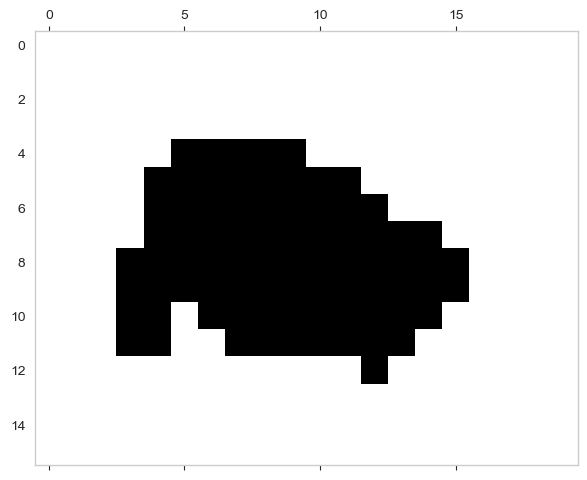

In [25]:
from IPython.display import Markdown
from skimage.io import imread
from skimage.morphology import label
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
seg_img = imread('ext-figures/aachen_label.png') == 26
seg_img = seg_img[::4, ::4]
seg_img = seg_img[110:130:2, 378:420:3] > 0
seg_img = np.pad(seg_img, 3, mode='constant')
_, (ax1) = plt.subplots(1, 1,
                        figsize=(7, 7),
                        dpi=100)
ax1.matshow(seg_img,
            cmap='bone_r');

In [27]:
x_coord, y_coord = [], []
for x in range(seg_img.shape[0]):
    for y in range(seg_img.shape[1]):
        if seg_img[x, y] == 1:
            x_coord += [x]
            y_coord += [y]
xmin = np.min(x_coord)
xmax = np.max(x_coord)
ymin = np.min(y_coord)
ymax = np.max(y_coord)
print('X -> ', 'Min:', xmin,
      'Max:', xmax)
print('Y -> ', 'Min:', ymin,
      'Max:', ymax)

X ->  Min: 4 Max: 12
Y ->  Min: 3 Max: 15


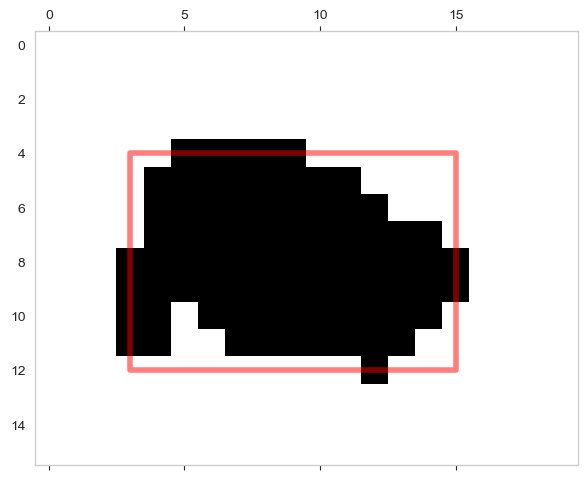

In [28]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
_, (ax1) = plt.subplots(1, 1,
                        figsize=(7, 7),
                        dpi=100)

ax1.matshow(seg_img,
            cmap='bone_r')

xw = (xmax-xmin)
yw = (ymax-ymin)

c_bbox = [Rectangle(xy=(ymin, xmin),
                    width=yw,
                    height=xw
                    )]
c_bb_patch = PatchCollection(c_bbox,
                             facecolor='none',
                             edgecolor='red',
                             linewidth=4,
                             alpha=0.5)
ax1.add_collection(c_bb_patch);

# Concrete Example
So how can we begin to apply the tools we have developed?

We take the original car scene from before.

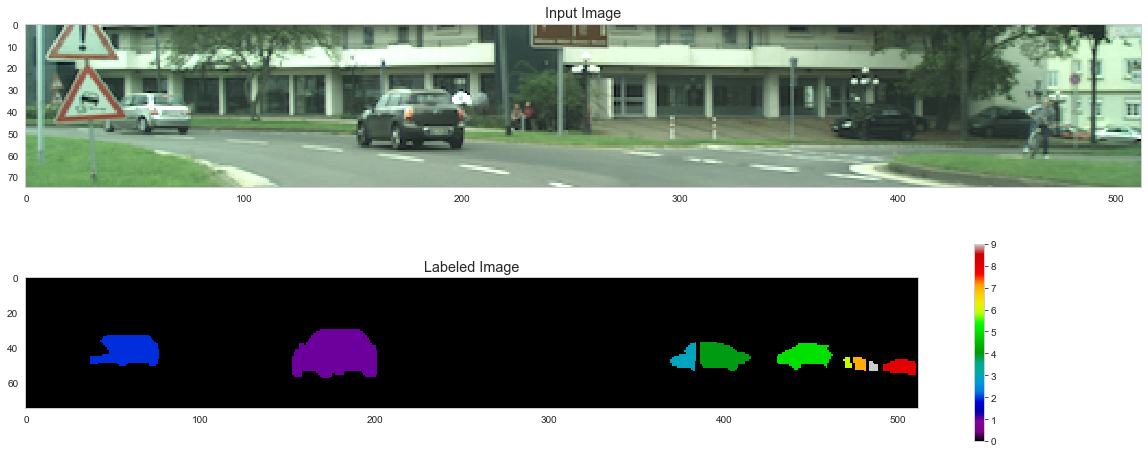

In [29]:
from skimage.measure import regionprops, label
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

car_img = np.clip(imread('ext-figures/aachen_img.png')
                  [75:150]*2.0, 0, 255).astype(np.uint8)
lab_img = label(imread('ext-figures/aachen_label.png')[::4, ::4] == 26)[75:150]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8))
ax1.imshow(car_img)
ax1.set_title('Input Image');

plt.colorbar(ax2.imshow(lab_img, cmap='nipy_spectral'))
ax2.set_title('Labeled Image');

# Shape Analysis
We can perform shape analysis on the image and calculate basic shape parameters for each object

Found  9 regions


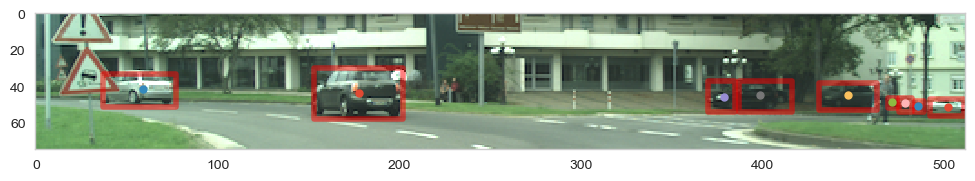

In [30]:
from skimage.measure import regionprops
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

# shape analysis

fig, ax1 = plt.subplots(1, 1, figsize=(12, 6), dpi=100)
ax1.imshow(car_img)
print('Found ', len(all_regions), 'regions')
bbox_list = []
for c_reg in all_regions:
    ax1.plot(c_reg.centroid[1], c_reg.centroid[0], 'o', markersize=5)
    bbox_list += [Rectangle(xy=(c_reg.bbox[1],
                                c_reg.bbox[0]),
                            width=c_reg.bbox[3]-c_reg.bbox[1],
                            height=c_reg.bbox[2]-c_reg.bbox[0]
                            )]
c_bb_patch = PatchCollection(bbox_list,
                             facecolor='none',
                             edgecolor='red',
                             linewidth=4,
                             alpha=0.5)
ax1.add_collection(c_bb_patch)

# Statistics
We can then generate a table full of these basic parameters for each object. In this case, we add color as an additional description

,label,bbox,area,centroid,color
0,1,"(30, 153, 58, 202)",1091,"(43.64527956003666, 177.82218148487627)",dimgrey
1,2,"(33, 37, 51, 77)",535,"(41.44299065420561, 58.7607476635514)",silver
2,3,"(37, 370, 54, 385)",140,"(45.871428571428574, 378.6642857142857)",darkslategray
3,4,"(37, 387, 54, 416)",342,"(44.86257309941521, 398.66959064327483)",darkslategray
4,5,"(38, 431, 53, 463)",323,"(44.526315789473685, 446.9133126934984)",darkslategray
5,6,"(46, 469, 52, 474)",22,"(48.63636363636363, 471.1818181818182)",dimgrey
6,7,"(46, 475, 54, 482)",44,"(49.09090909090909, 478.22727272727275)",dimgrey
7,8,"(47, 492, 56, 511)",134,"(50.992537313432834, 501.82089552238807)",powderblue
8,9,"(48, 484, 54, 489)",25,"(50.92, 485.76)",grey


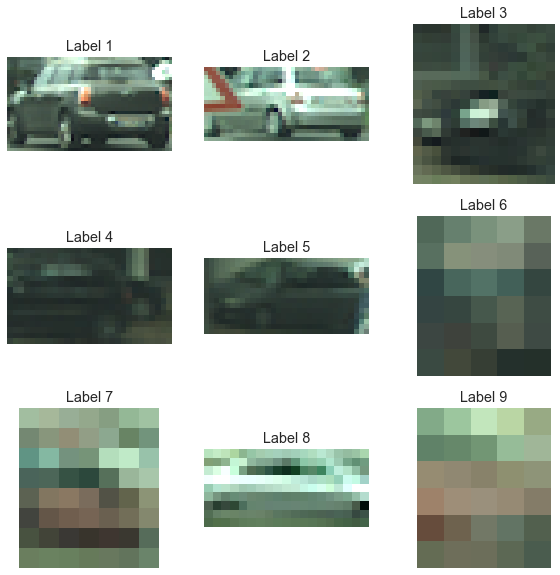

In [31]:
from sklearn.neighbors import KNeighborsClassifier
import webcolors
import pandas as pd
from skimage.morphology import erosion, disk


def ed_img(in_img):
    # shrink an image to a few pixels
    cur_img = in_img.copy()
    while cur_img.max() > 0:
        last_img = cur_img
        cur_img = erosion(cur_img, disk(1))
    return last_img


# guess color name based on rgb value
color_name_class = KNeighborsClassifier(1)
c_names = sorted(webcolors.css3_names_to_hex.keys())
color_name_class.fit([tuple(webcolors.name_to_rgb(k)) for k in c_names],
                     c_names)


reg_df = pd.DataFrame([dict(label=c_reg.label,
                            bbox=c_reg.bbox,
                            area=c_reg.area,
                            centroid=c_reg.centroid,
                            color=color_name_class.predict(np.mean(car_img[ed_img(lab_img == c_reg.label)], 0)[:3].reshape((1, -1)))[0])
                       for c_reg in all_regions])
fig, m_axs = plt.subplots(np.floor(len(all_regions)/3).astype(int),3, figsize=(10,10))
for c_ax, c_reg in zip(m_axs.ravel(), all_regions):
    c_ax.imshow(car_img[c_reg.bbox[0]:c_reg.bbox[2],
                        c_reg.bbox[1]:c_reg.bbox[3]
                        ])
    c_ax.axis('off')
    c_ax.set_title('Label {}'.format(c_reg.label))
reg_df

# Object anisotropy

Anisotropy: What is it?
===
By definition (New Oxford American): ```varying in magnitude according to the direction of measurement.```

- It allows us to define metrics in respect to one another and thereby characterize shape.
- Is it:
    - tall and skinny, 
    - short and fat, 
    - or perfectly round

# A very vague definition
It can be mathematically characterized in many different very much unequal ways (in all cases 0 represents a sphere)

$$ Aiso1 = \frac{\text{Longest Side}}{\text{Shortest Side}} - 1 $$

$$ Aiso2 = \frac{\text{Longest Side}-\text{Shortest Side}}{\text{Longest Side}} $$

$$ Aiso3 = \frac{\text{Longest Side}}{\text{Average Side Length}} - 1 $$

$$ Aiso4 = \frac{\text{Longest Side}-\text{Shortest Side}}{\text{Average Side Length}} $$

$$ \cdots \rightarrow \text{ ad nauseum} $$

In [32]:
from collections import defaultdict
from skimage.measure import regionprops
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

xx, yy = np.meshgrid(np.linspace(-5, 5, 100),
                     np.linspace(-5, 5, 100))


def side_len(c_reg): return sorted(
    [c_reg.bbox[3]-c_reg.bbox[1], c_reg.bbox[2]-c_reg.bbox[0]])


aiso_funcs = [lambda x: side_len(x)[-1]/side_len(x)[0]-1,
              lambda x: (side_len(x)[-1]-side_len(x)[0])/side_len(x)[-1],
              lambda x: side_len(x)[-1]/np.mean(side_len(x))-1,
              lambda x: (side_len(x)[-1]-side_len(x)[0])/np.mean(side_len(x))]


def ell_func(a, b): return np.sqrt(np.square(xx/a)+np.square(yy/b)) <= 1

In [33]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
fig, m_axs = plt.subplots(2, 3,
                          figsize=(12, 8),
                          dpi=72)
ab_list = [(2, 2), (2, 3), (2, 4), (2, 5), (1.5, 5),
           (1, 5), (0.5, 5), (0.1, 5),  (0.05, 5)]
func_pts = defaultdict(list)


def update_frame(i):
    plt.cla()
    a, b = ab_list[i]
    c_img = ell_func(a, b)
    m_axs[0, 0].imshow(c_img, cmap='gist_earth')
    reg_info = regionprops(c_img.astype(int))[0]
    m_axs[0, 0].set_title('Shape #{}'.format(i+1))
    for j, (c_func, c_ax) in enumerate(zip(aiso_funcs, m_axs.flatten()[1:]), 1):
        func_pts[j] += [c_func(reg_info)]
        c_ax.plot(func_pts[j], 'r-')
        c_ax.set_title('Anisotropy #{}'.format(j))
        c_ax.set_ylim(-.1, 3)
    m_axs.flatten()[-1].axis('off')


# write animation frames
anim_code = FuncAnimation(fig,
                          update_frame,
                          frames=len(ab_list)-1,
                          interval=500,
                          repeat_delay=1000).to_html5_video()
plt.close('all')
HTML(anim_code)

# Statistical tools

# Useful Statistical Tools

While many of the topics covered in 

- Linear Algebra 
- and Statistics courses 

might not seem very applicable to real problems at first glance.

at least a few of them come in handy for dealing distributions of pixels 

_(they will only be briefly covered, for more detailed review look at some of the suggested material)_

# Principal Component Analysis
- Similar to K-Means insofar as we start with a series of points in a vector space and want to condense the information. 

With PCA
- doesn't search for distinct groups, 
- we find a linear combination of components which best explain the variance in the system.

## PCA on spectroscopy
As an example we will use a very simple example from spectroscopy:

,cm^(-1),intensity
0,1000.000000,0.060794
1,1010.033445,0.319896
2,1020.066890,0.815822
3,1030.100334,0.010663
4,1040.133779,0.785761


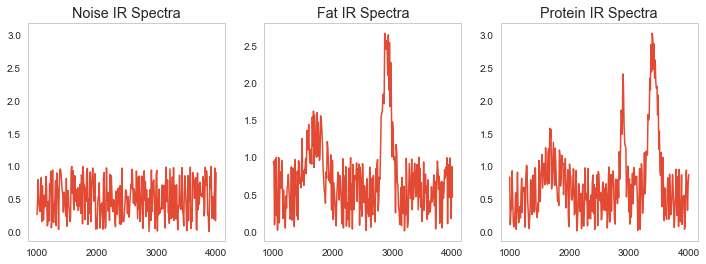

In [35]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

cm_dm = np.linspace(1000, 4000, 300)


def peak(cent, wid, h): return h/(wid*np.sqrt(2*np.pi)) * \
    np.exp(-np.square((cm_dm-cent)/wid))


def peaks(plist): return np.sum(np.stack(
    [peak(cent, wid, h) for cent, wid, h in plist], 0), 0)+np.random.uniform(0, 1, size=cm_dm.shape)


fat_curve = [(2900, 100, 500), (1680, 200, 400)]
protein_curve = [(2900, 50, 200), (3400, 100, 600), (1680, 200, 300)]
noise_curve = [(3000, 50, 1)]

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 4))

ax1.plot(cm_dm, peaks(fat_curve))
ax1.set_title('Fat IR Spectra')

ax2.plot(cm_dm, peaks(protein_curve))
ax2.set_title('Protein IR Spectra')

ax0.plot(cm_dm, peaks(noise_curve))
ax0.set_title('Noise IR Spectra')

ax0.set_ylim(ax2.get_ylim())
ax2.set_ylim(ax2.get_ylim())

pd.DataFrame({'cm^(-1)': cm_dm, 'intensity': peaks(protein_curve)}).head(5)

# Test Dataset of a number of curves
We want to sort cells or samples into groups of being 
- more fat like 
- or more protein like. 

## How can we analyze this data without specifically looking for peaks or building models?

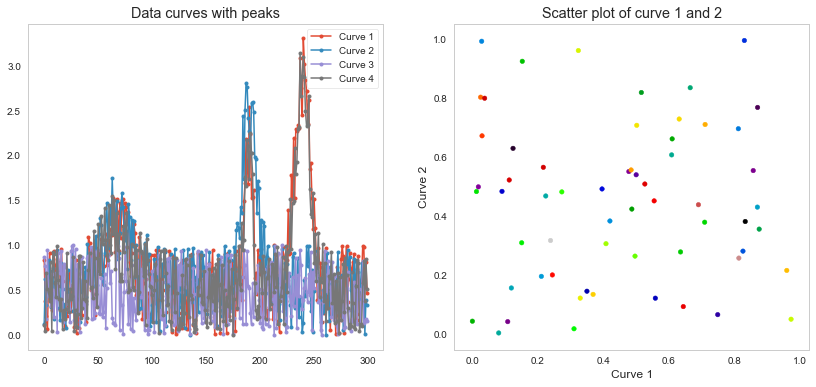

In [36]:
test_data = np.stack([peaks(c_curve) for _ in range(20)
                      for c_curve in [protein_curve, fat_curve, noise_curve]], 0)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(test_data[:4].T, '.-')
ax1.legend(['Curve 1', 'Curve 2', 'Curve 3', 'Curve 4'])
ax1.set_title('Data curves with peaks')
ax2.scatter(test_data[:, 0], test_data[:,1], c=range(test_data.shape[0]),
            s=20, cmap='nipy_spectral')
ax2.set_title('Scatter plot of curve 1 and 2'); ax2.set_xlabel('Curve 1'); ax2.set_ylabel('Curve 2'); 

In [37]:
from sklearn.decomposition import PCA
pca_tool = PCA(5)
pca_tool.fit(test_data)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

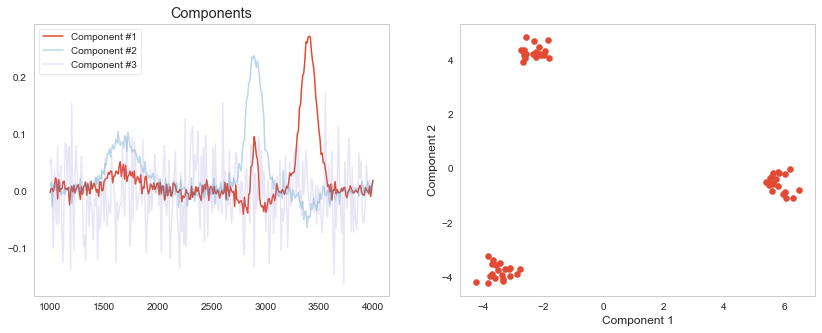

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
score_matrix = pca_tool.transform(test_data)
ax1.plot(cm_dm, pca_tool.components_[0, :], label='Component #1')
ax1.plot(cm_dm, pca_tool.components_[
         1, :], label='Component #2', alpha=pca_tool.explained_variance_ratio_[0])
ax1.plot(cm_dm, pca_tool.components_[
         2, :], label='Component #3', alpha=pca_tool.explained_variance_ratio_[1])
ax1.legend(), ax1.set_title('Components')
ax2.scatter(score_matrix[:, 0],
            score_matrix[:, 1])
ax2.set_xlabel('Component 1')
ax2.set_ylabel('Component 2');

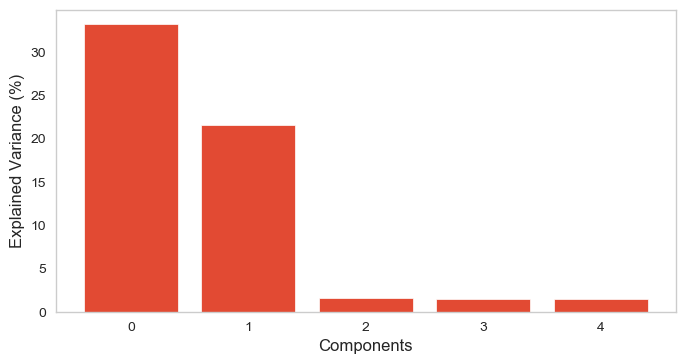

In [39]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 4), dpi=100)
ax1.bar(x=range(pca_tool.explained_variance_ratio_.shape[0]),
        height=100*pca_tool.explained_variance_ratio_)
ax1.set_xlabel('Components')
ax1.set_ylabel('Explained Variance (%)');

# Principal Component Analysis
## scikit-learn [Face Analyis](http://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html)

Here we show a more imaging related example from the scikit-learn documentation where we do basic face analysis with scikit-learn.


In [40]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn import decomposition
# Load faces data
try:
    dataset = fetch_olivetti_faces(
        shuffle=True, random_state=2018, data_home='.')
    faces = dataset.data
except Exception as e:
    print('Face data not available', e)
    faces = np.random.uniform(0, 1, (400, 4096))

n_samples, n_features = faces.shape
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)

Dataset consists of 400 faces


Extracting the top 6 Eigenfaces - PCA using randomized SVD...


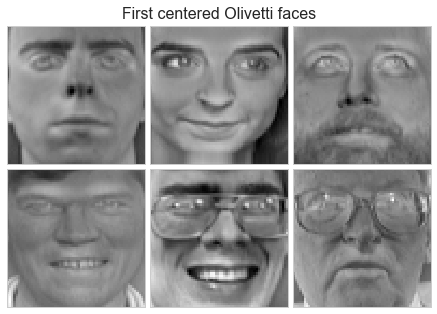

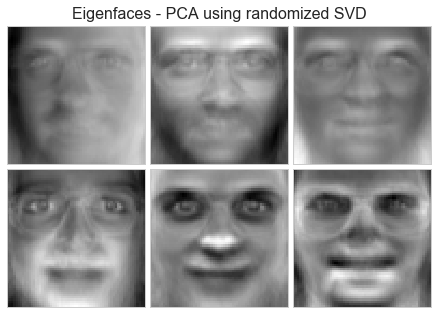

In [41]:
def plot_gallery(title, images, n_col=n_col, n_row=n_row):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)


# #############################################################################
# List of the different estimators, whether to center and transpose the
# problem, and whether the transformer uses the clustering API.
estimators = [
    ('Eigenfaces - PCA using randomized SVD',
     decomposition.PCA(n_components=n_components, svd_solver='randomized',
                       whiten=True),
     True)]
# #############################################################################
# Plot a sample of the input data

plot_gallery("First centered Olivetti faces", faces_centered[:n_components])

# #############################################################################
# Do the estimation and plot it

for name, estimator, center in estimators:
    print("Extracting the top %d %s..." % (n_components, name))
    data = faces
    if center:
        data = faces_centered
    estimator.fit(data)

    if hasattr(estimator, 'cluster_centers_'):
        components_ = estimator.cluster_centers_
    else:
        components_ = estimator.components_
    plot_gallery(name,
                 components_[:n_components])

plt.show()

# Applied PCA: Shape Tensor

## How do these statistical analyses help us?
Going back to a single cell, we have the a distribution of $x$ and $y$ values.
- are not however completely independent
- greatest variance does not normally lie in either x nor y alone. 

A principal component analysis of the voxel positions, will calculate two new principal components (the components themselves are the relationships between the input variables and the scores are the final values.)
- An optimal rotation of the coordinate system

We start off by calculating the covariance matrix from the list of $x$, $y$, and $z$ points that make up our object of interest.

$$ COV(I_{id}) = \frac{1}{N} \sum_{\forall\vec{v}\in I_{id}} \begin{bmatrix}
\vec{v}_x\vec{v}_x & \vec{v}_x\vec{v}_y & \vec{v}_x\vec{v}_z\\
\vec{v}_y\vec{v}_x & \vec{v}_y\vec{v}_y & \vec{v}_y\vec{v}_z\\
\vec{v}_z\vec{v}_x & \vec{v}_z\vec{v}_y & \vec{v}_z\vec{v}_z
\end{bmatrix} $$

We then take the eigentransform of this array to obtain the eigenvectors (principal components, $\vec{\Lambda}_{1\cdots 3}$) and eigenvalues (scores, $\lambda_{1\cdots 3}$)

$$ COV(I_{id}) \longrightarrow \underbrace{\begin{bmatrix}
\vec{\Lambda}_{1x} & \vec{\Lambda}_{1y} & \vec{\Lambda}_{1z} \\
\vec{\Lambda}_{2x} & \vec{\Lambda}_{2y} & \vec{\Lambda}_{2z} \\
\vec{\Lambda}_{3x} & \vec{\Lambda}_{3y} & \vec{\Lambda}_{3z} 
\end{bmatrix}}_{\textrm{Eigenvectors}} * \underbrace{\begin{bmatrix} 
\lambda_1 & 0 & 0 \\ 
0 & \lambda_2 & 0 \\
0 & 0 & \lambda_3
\end{bmatrix}}_{\textrm{Eigenvalues}} * \underbrace{\begin{bmatrix}
\vec{\Lambda}_{1x} & \vec{\Lambda}_{1y} & \vec{\Lambda}_{1z} \\
\vec{\Lambda}_{2x} & \vec{\Lambda}_{2y} & \vec{\Lambda}_{2z} \\
\vec{\Lambda}_{3x} & \vec{\Lambda}_{3y} & \vec{\Lambda}_{3z} 
\end{bmatrix}^{T}}_{\textrm{Eigenvectors}} $$
The principal components tell us about the orientation of the object and the scores tell us about the corresponding magnitude (or length) in that direction.

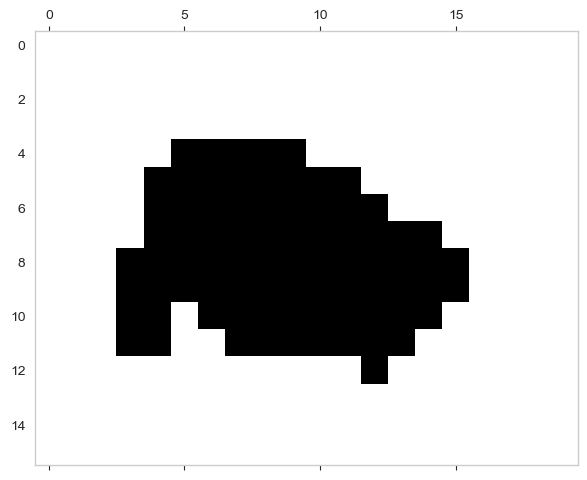

In [42]:
from IPython.display import Markdown
from skimage.io import imread
from skimage.morphology import label
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
seg_img = imread('ext-figures/aachen_label.png') == 26
seg_img = seg_img[::4, ::4]
seg_img = seg_img[110:130:2, 378:420:3] > 0
seg_img = np.pad(seg_img, 3, mode='constant')
seg_img[0, 0] = 0
_, (ax1) = plt.subplots(1, 1, figsize=(7, 7), dpi=100)
ax1.matshow(seg_img, cmap='bone_r');

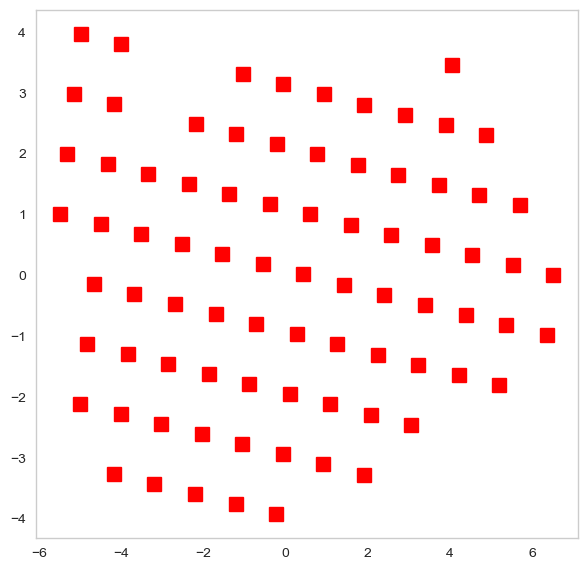

In [43]:
from sklearn.decomposition import PCA
x_coord, y_coord = np.where(seg_img > 0)
xy_pts = np.stack([x_coord, y_coord], 1)
shape_pca = PCA()
shape_pca.fit(xy_pts)
pca_xy_vals = shape_pca.transform(xy_pts)
_, (ax1) = plt.subplots(1, 1,
                        figsize=(7, 7),
                        dpi=100)
ax1.plot(pca_xy_vals[:, 0], pca_xy_vals[:, 1], 'rs', markersize=10)

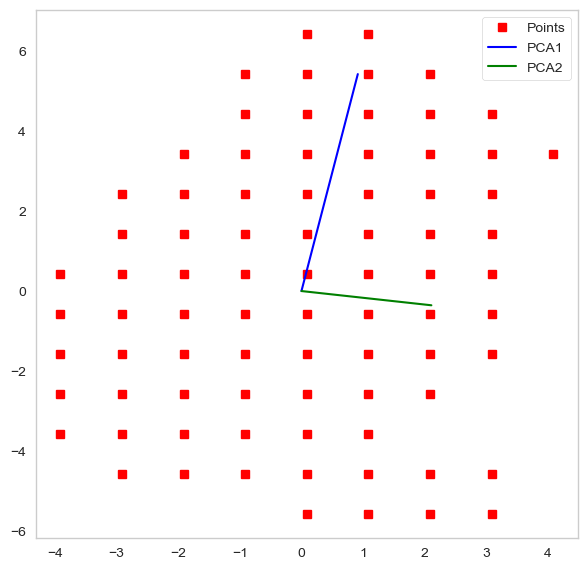

In [44]:
_, (ax1) = plt.subplots(1, 1,
                        figsize=(7, 7),
                        dpi=100)


ax1.plot(xy_pts[:, 0]-np.mean(xy_pts[:, 0]),
         xy_pts[:, 1]-np.mean(xy_pts[:, 1]), 'rs', label='Points')
ax1.plot([0, shape_pca.explained_variance_[0]/2*shape_pca.components_[0, 0]],
         [0, shape_pca.explained_variance_[0]/2*shape_pca.components_[0, 1]], 'b-',
         label='PCA1'
         )
ax1.plot([0, shape_pca.explained_variance_[1]/2*shape_pca.components_[1, 0]],
         [0, shape_pca.explained_variance_[1]/2*shape_pca.components_[1, 1]], 'g-',
         label='PCA2'
         )
ax1.legend();

# Principal Component Analysis: Take home message

- We calculate the statistical distribution individually for $x$, $y$, and $z$ and the 'correlations' between them.
- From these values we can estimate the orientation in the direction of largest variance
- We can also estimate magnitude
- These functions are implemented as ```princomp``` or ```pca``` in various languages and scale well to very large datasets.

# Principal Component Analysis: Elliptical Model


While the eigenvalues and eigenvectors are in their own right useful
- Not obvious how to visually represent these tensor objects
- Ellipsoidal (Ellipse in 2D) representation alleviates this issue

### Ellipsoidal Representation
1. Center of Volume is calculated normally
1. Eigenvectors represent the unit vectors for the semiaxes of the ellipsoid
1. $\sqrt{\text{Eigenvalues}}$ is proportional to the length of the semiaxis ($\mathcal{l}=\sqrt{5\lambda_i}$), derivation similar to moment of inertia tensor for ellipsoids.

***

# Meshing


# Meshing

The process of turning a (connected) set of pixels into a list of vertices and edges

- For these vertices and edges we can define forces. 
- Most crucially this comes when looking at physical processes like deformation.
- Meshes are also useful for visualization.


### Example
Looking at stress-strain relationships in mechanics using Hooke's Model 

$$ \vec{F}=k (\vec{x}_0-\vec{x}) $$ 

the force needed to stretch one of these edges is proportional to how far it is stretched. 

# Meshing


Since we uses voxels to image and identify the volume we can use the voxels themselves as an approimation for the surface of the structure. 
- Each 'exposed' face of a voxel belongs to the surface

From this we can create a mesh by 

- adding each exposed voxel face to a list of surface squares. 
- adding connectivity information for the different squares (shared edges and vertices)

A wide variety of methods of which we will only graze the surface (http://en.wikipedia.org/wiki/Image-based_meshing)

# Marching Cubes

### Why
Voxels are very poor approximations for the surface and are very rough (they are either normal to the x, y, or z axis and nothing between).

<img src="../common/figures/sphere_comparison.svg" style="height:150px" />

### [How](https://en.wikipedia.org/wiki/Marching_cubes)
1. The image is processed one voxel at a time 
2. The 2x2x2 neighborhood is checked at every voxel. 
3. From this configuration of values, faces are added to the mesh to incorporate the most simple surface which would explain the values. 

This algortihm is nicely explained in this [video](https://youtu.be/M3iI2l0ltbE)

[Marching tetrahedra](http://en.wikipedia.org/wiki/Marching_tetrahedra) is for some applications a better suited approach

# Next Time on QBI


So, while bounding box and ellipse-based models are useful for many object and cells, they do a very poor job with other samples


***

### Why
- We assume an entity consists of connected pixels (wrong)
- We assume the objects are well modeled by an ellipse (also wrong)

### What to do?

- Is it 3 connected objects which should all be analzed seperately?
- If we could __divide it__, we could then analyze each spart as an ellipse
- Is it one network of objects and we want to know about the constrictions?
- Is it a cell or organelle with docking sites for cell?
- Neither extents nor anisotropy are very meaningful, we need a __more specific metric__ which can characterize